In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_22424\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_22424\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [3]:
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

sample_image = sample_image.astype(np.float32)

for c in range(sample_image.shape[-1]):
    band = sample_image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        sample_image[:, :, c] = (band - min_val) / (max_val - min_val)


Image shape: (128, 128, 12)
Mask shape: (128, 128)


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


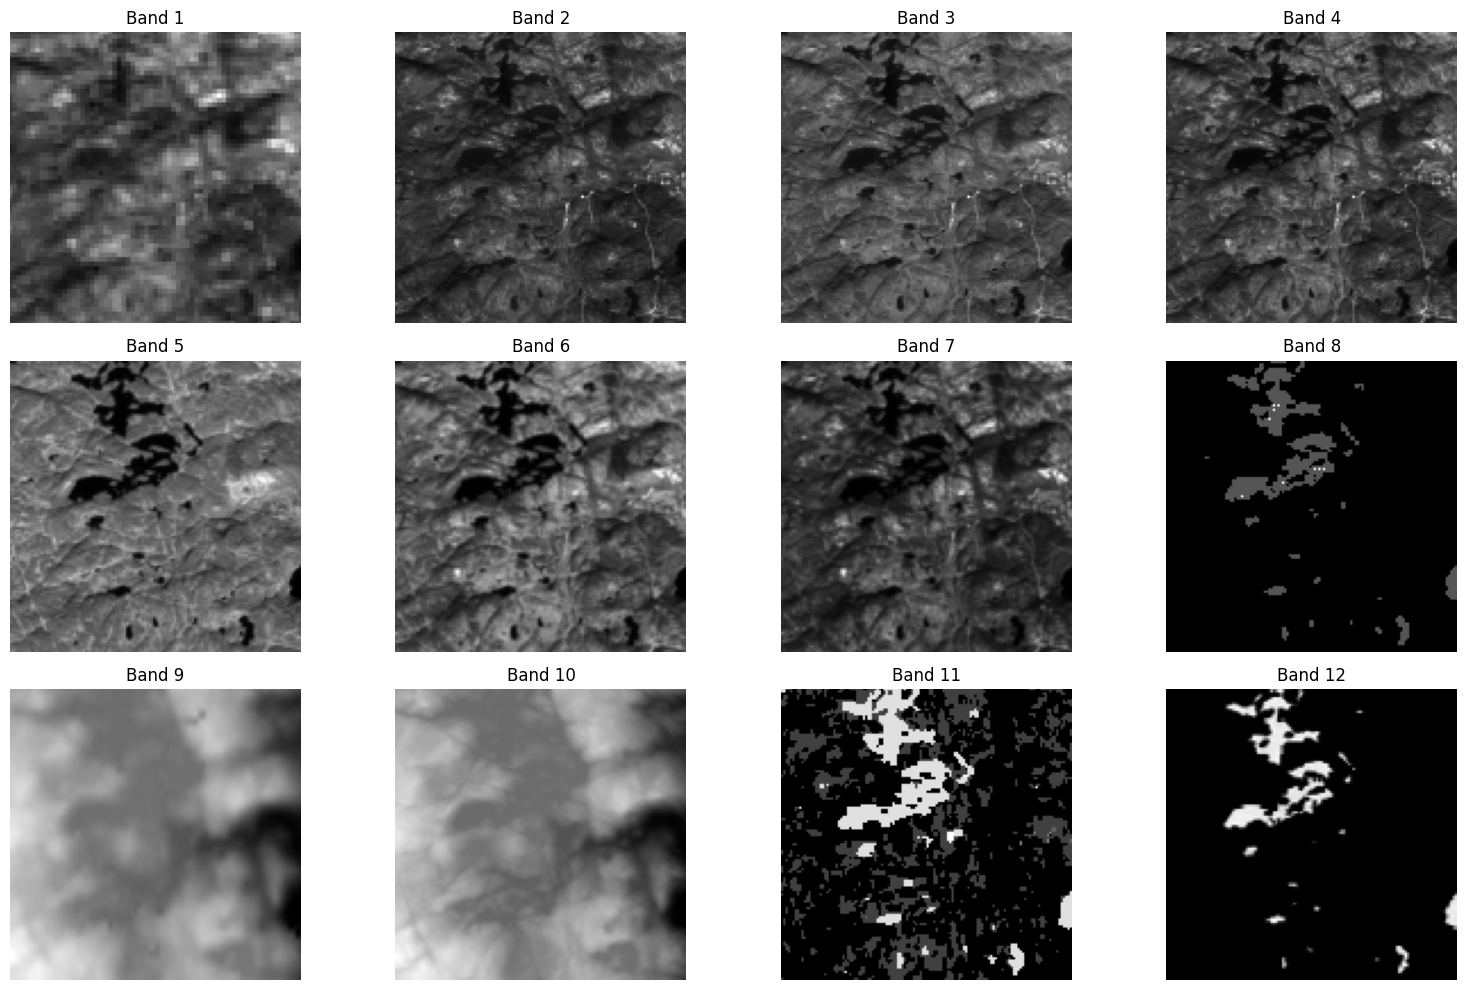

In [4]:
plt.figure(figsize=(16,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
selected_bands = [0, 1, 4, 5, 6, 11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)


        with rasterio.open(img_path) as src:
            image = src.read()  

        image = np.transpose(image, (1, 2, 0))  
        image = image[:, :, selected_bands]
        image = image.astype(np.float32)


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise ValueError(f"Mask not found: {mask_path}")

        mask = (mask > 0).astype(np.float32)  
        image = torch.tensor(image).permute(2, 0, 1)  
        mask = torch.tensor(mask).unsqueeze(0)       

        return image, mask


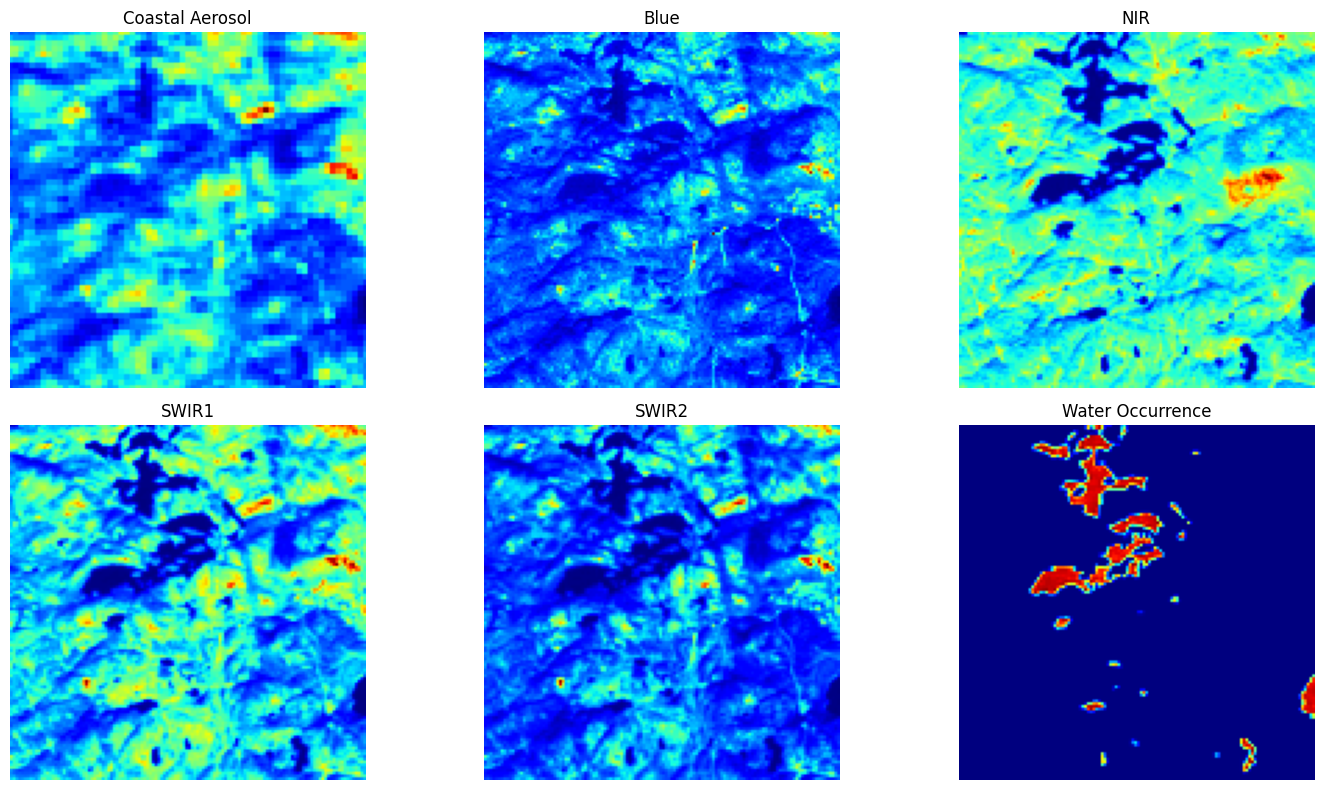

In [8]:
plt.figure(figsize=(15,8))

band_names = [
    "Coastal Aerosol",
    "Blue",
    "NIR",
    "SWIR1",
    "SWIR2",
    "Water Occurrence"
]

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_image[:,:,selected_bands[i]], cmap='jet')
    plt.title(band_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


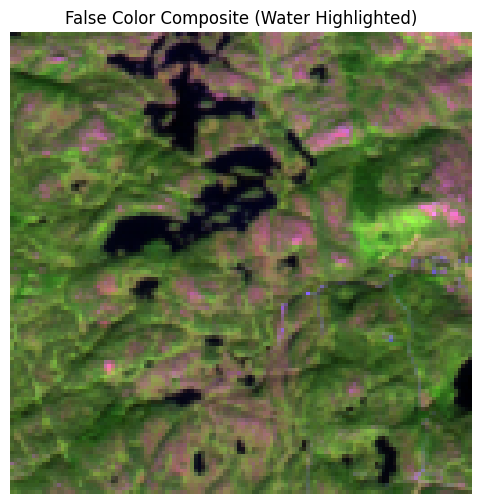

In [ ]:
nir = sample_image[:,:,4]
swir1 = sample_image[:,:,5]
blue = sample_image[:,:,1]

rgb_water = np.stack([swir1, nir, blue], axis=-1)

plt.figure(figsize=(6,6))
plt.imshow(rgb_water)
plt.title("(Water Highlighted)")
plt.axis("off")
plt.show()


In [10]:
from torch.utils.data import Subset

full_dataset = WaterDataset(image_dir, label_dir)
indices = list(range(len(full_dataset)))

train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


Train size: 214
Validation size: 46
Test size: 46


In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=6, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [25]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    return iou.item(), dice.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou, dice = calculate_metrics(preds, masks)
        train_iou += iou
        train_dice += dice

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)
            val_iou += iou
            val_dice += dice

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f} | Dice:{train_dice:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f} | Dice:{val_dice:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.59it/s, val_loss=0.165]



Epoch 1
Train -> Loss:0.1704 | IoU:0.8184 | Dice:0.8994
Val   -> Loss:0.1906 | IoU:0.7631 | Dice:0.8644



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s, val_loss=0.173]



Epoch 2
Train -> Loss:0.1632 | IoU:0.8248 | Dice:0.9035
Val   -> Loss:0.1866 | IoU:0.7657 | Dice:0.8662



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, val_loss=0.183]



Epoch 3
Train -> Loss:0.1505 | IoU:0.8489 | Dice:0.9179
Val   -> Loss:0.1958 | IoU:0.7536 | Dice:0.8579



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s, val_loss=0.165]



Epoch 4
Train -> Loss:0.1473 | IoU:0.8475 | Dice:0.9170
Val   -> Loss:0.1883 | IoU:0.7659 | Dice:0.8662



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.193]



Epoch 5
Train -> Loss:0.1553 | IoU:0.8235 | Dice:0.9019
Val   -> Loss:0.2052 | IoU:0.7432 | Dice:0.8516



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, val_loss=0.161]



Epoch 6
Train -> Loss:0.1478 | IoU:0.8428 | Dice:0.9142
Val   -> Loss:0.1914 | IoU:0.7535 | Dice:0.8582



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.157]



Epoch 7
Train -> Loss:0.1401 | IoU:0.8577 | Dice:0.9229
Val   -> Loss:0.1764 | IoU:0.7716 | Dice:0.8700



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s, val_loss=0.151]



Epoch 8
Train -> Loss:0.1371 | IoU:0.8583 | Dice:0.9229
Val   -> Loss:0.1780 | IoU:0.7796 | Dice:0.8752



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.17] 



Epoch 9
Train -> Loss:0.1385 | IoU:0.8509 | Dice:0.9181
Val   -> Loss:0.1873 | IoU:0.7634 | Dice:0.8644



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.176]



Epoch 10
Train -> Loss:0.1368 | IoU:0.8559 | Dice:0.9217
Val   -> Loss:0.1888 | IoU:0.7615 | Dice:0.8637



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.175]



Epoch 11
Train -> Loss:0.1316 | IoU:0.8571 | Dice:0.9220
Val   -> Loss:0.1840 | IoU:0.7675 | Dice:0.8673



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.158]



Epoch 12
Train -> Loss:0.1243 | IoU:0.8737 | Dice:0.9323
Val   -> Loss:0.1784 | IoU:0.7707 | Dice:0.8694



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.14] 



Epoch 13
Train -> Loss:0.1255 | IoU:0.8698 | Dice:0.9295
Val   -> Loss:0.1629 | IoU:0.7888 | Dice:0.8811



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s, val_loss=0.15] 



Epoch 14
Train -> Loss:0.1275 | IoU:0.8706 | Dice:0.9302
Val   -> Loss:0.1669 | IoU:0.7813 | Dice:0.8763



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s, val_loss=0.153]



Epoch 15
Train -> Loss:0.1268 | IoU:0.8648 | Dice:0.9273
Val   -> Loss:0.1804 | IoU:0.7653 | Dice:0.8660



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.149]



Epoch 16
Train -> Loss:0.1272 | IoU:0.8559 | Dice:0.9207
Val   -> Loss:0.1720 | IoU:0.7745 | Dice:0.8716



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.166]



Epoch 17
Train -> Loss:0.1194 | IoU:0.8794 | Dice:0.9355
Val   -> Loss:0.1755 | IoU:0.7766 | Dice:0.8731



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s, val_loss=0.151]



Epoch 18
Train -> Loss:0.1153 | IoU:0.8783 | Dice:0.9344
Val   -> Loss:0.1735 | IoU:0.7727 | Dice:0.8706



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.147]



Epoch 19
Train -> Loss:0.1325 | IoU:0.8811 | Dice:0.9363
Val   -> Loss:0.1744 | IoU:0.7720 | Dice:0.8700



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s, val_loss=0.19] 


Epoch 20
Train -> Loss:0.1233 | IoU:0.8652 | Dice:0.9274
Val   -> Loss:0.1907 | IoU:0.7448 | Dice:0.8522



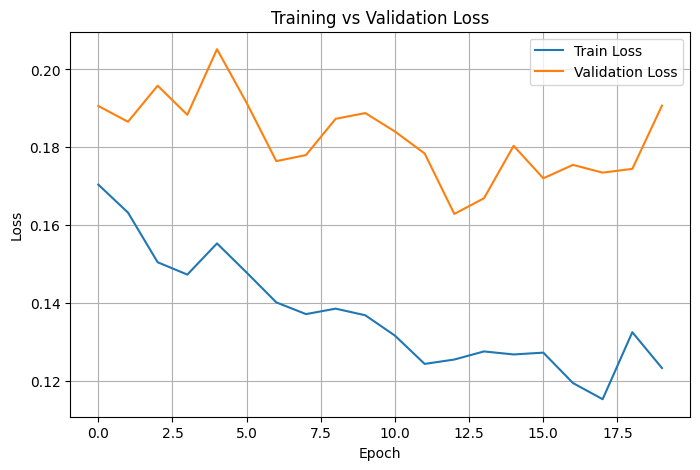

In [26]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Eval:
Precision: 0.7014
Recall:    0.9114
IoU:       0.6566
F1-score:  0.7927


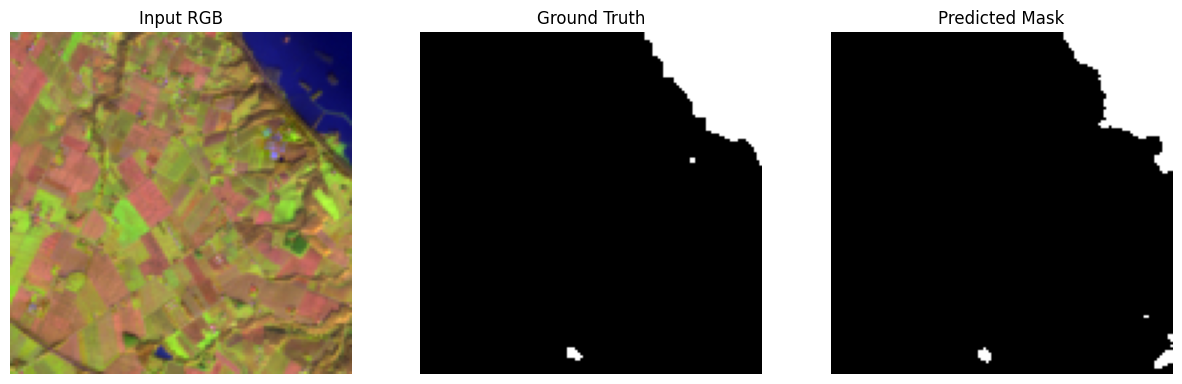

In [28]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

# Move to CPU
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


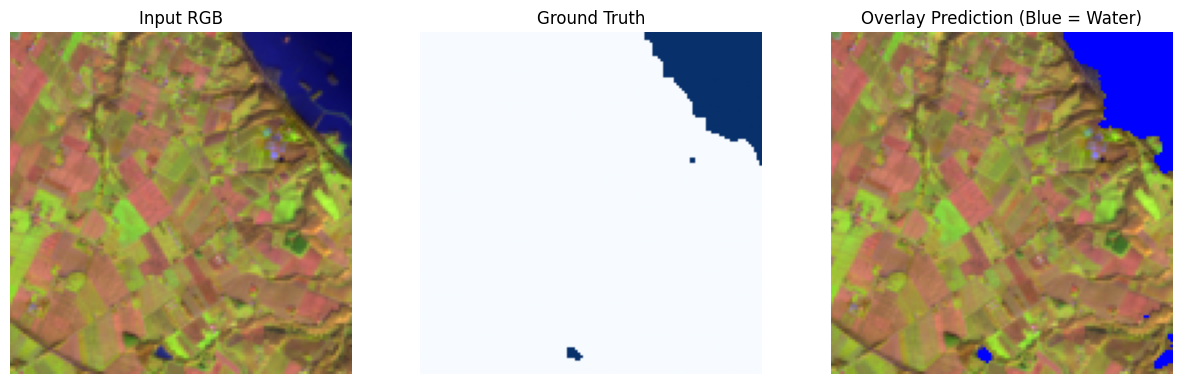

In [29]:

rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


In [30]:
bands_A = list(range(12))
bands_B = [0, 1, 4, 5, 6, 11]
bands_C = [3, 2, 1]  # R,G,B
bands_D = [4, 5, 6]
bands_E = [0, 1, 4, 5, 6, 11]  # + NDWI computed later


In [31]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, add_ndwi=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.add_ndwi = add_ndwi

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            image = src.read()

        image = np.transpose(image, (1,2,0)).astype(np.float32)

        # Select bands
        image = image[:, :, self.selected_bands]

        # NDWI calculation if needed
        if self.add_ndwi:
            green = image[:, :, 2] if 2 in self.selected_bands else image[:, :, 1]
            nir = image[:, :, 4] if 4 in self.selected_bands else image[:, :, -1]

            ndwi = (green - nir) / (green + nir + 1e-8)
            ndwi = np.expand_dims(ndwi, axis=-1)

            image = np.concatenate([image, ndwi], axis=-1)

        # Normalize per channel
        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [32]:
def train_model(selected_bands, add_ndwi=False, epochs=15):

    dataset = WaterDataset(image_dir, label_dir, selected_bands, add_ndwi)
    
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4)
    test_loader = DataLoader(test_dataset, batch_size=4)

    in_channels = len(selected_bands) + (1 if add_ndwi else 0)
    model = UNet(in_channels=in_channels, out_channels=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_val_iou = 0

    for epoch in range(epochs):
        model.train()
        train_iou = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            iou, _ = calculate_metrics(preds, masks)
            train_iou += iou

        train_iou /= len(train_loader)

        # Validation
        model.eval()
        val_iou = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                preds = (torch.sigmoid(outputs) > 0.5).float()

                iou, _ = calculate_metrics(preds, masks)
                val_iou += iou

        val_iou /= len(val_loader)

        print(f"Epoch {epoch+1}: Train IoU={train_iou:.4f} | Val IoU={val_iou:.4f}")

        if val_iou > best_val_iou:
            best_val_iou = val_iou

    return best_val_iou


In [33]:
results = {}

results["All 12"] = train_model(bands_A)
results["6 Water Bands"] = train_model(bands_B)
results["RGB"] = train_model(bands_C)
results["NIR+SWIR"] = train_model(bands_D)
results["6 Bands + NDWI"] = train_model(bands_B, add_ndwi=True)

print("\nFinal Validation IoU Comparison:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Epoch 1: Train IoU=0.4405 | Val IoU=0.0422
Epoch 2: Train IoU=0.5215 | Val IoU=0.0422
Epoch 3: Train IoU=0.5323 | Val IoU=0.0422
Epoch 4: Train IoU=0.5593 | Val IoU=0.0422
Epoch 5: Train IoU=0.5769 | Val IoU=0.0422
Epoch 6: Train IoU=0.5767 | Val IoU=0.0422
Epoch 7: Train IoU=0.6025 | Val IoU=0.0422
Epoch 8: Train IoU=0.5893 | Val IoU=0.0422
Epoch 9: Train IoU=0.5765 | Val IoU=0.0422
Epoch 10: Train IoU=0.5992 | Val IoU=0.0422
Epoch 11: Train IoU=0.6066 | Val IoU=0.0422
Epoch 12: Train IoU=0.5873 | Val IoU=0.0422
Epoch 13: Train IoU=0.5638 | Val IoU=0.0422
Epoch 14: Train IoU=0.6242 | Val IoU=0.0422
Epoch 15: Train IoU=0.5994 | Val IoU=0.0422
Epoch 1: Train IoU=0.5030 | Val IoU=0.5956
Epoch 2: Train IoU=0.5699 | Val IoU=0.6103
Epoch 3: Train IoU=0.5720 | Val IoU=0.6252
Epoch 4: Train IoU=0.5382 | Val IoU=0.6313
Epoch 5: Train IoU=0.5807 | Val IoU=0.6447
Epoch 6: Train IoU=0.6006 | Val IoU=0.6170
Epoch 7: Train IoU=0.5821 | Val IoU=0.6367
Epoch 8: Train IoU=0.6087 | Val IoU=0.6217
Epoch

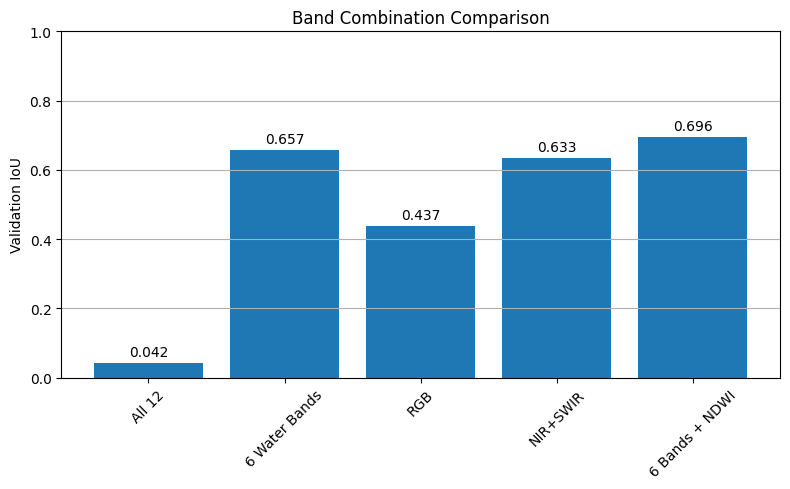

In [34]:
import matplotlib.pyplot as plt

# Extract names and values
model_names = list(results.keys())
iou_scores = list(results.values())

plt.figure(figsize=(8,5))
plt.bar(model_names, iou_scores)
plt.xticks(rotation=45)
plt.ylabel("Validation IoU")
plt.title("Band Combination Comparison")
plt.ylim(0, 1)
plt.grid(axis="y")

for i, v in enumerate(iou_scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()
